output composites based on TREFHT percentiles

In [1]:
import importlib
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys

from CASutils import filter_utils as filt
from CASutils import calendar_utils as cal

importlib.reload(filt)
importlib.reload(cal)

<module 'CASutils.calendar_utils' from '/home/islas/python/CASanalysis/CASutils/calendar_utils.py'>

In [10]:
# deseasonalize by filtering out the first 4 harmonics of the seasonal cycle and then removing the seasonal mean of each year
def calcdeseas(da):
    datseas = da.groupby('time.dayofyear').mean('time')
    dat4harm = filt.calc_season_nharm(datseas, 4, dimtime=0)
    anoms = da.groupby('time.dayofyear') - dat4harm
    datdeseas = cal.group_season_daily(anoms, 'DJF')
    seasmean = datdeseas.mean('day')
    datdeseas = datdeseas - seasmean
    datdeseas = np.array(datdeseas).flatten()
    return datdeseas

In [31]:
def sortfnetdata(fnetdata):
    data = xr.open_dataset(fnetdata)
    data = data.sel(time=~((data.time.dt.month == 2) & (data.time.dt.day == 29)))
    
    #quality control
    shflx = data.shflx.where(data.shflx_qc > 0.5)
    tas = data.tas.where(data.tas_qc > 0.5)
    g = data.g.where( (data.g_qc > 0.5) & (data.g > -999))
    netrad = data.netrad.where( (data.netrad_qc > 0.5))
    
    daystr = xr.DataArray(data.indexes['time'].strftime('%m-%d'), coords = data.time.coords, name='daystr')
    
    shflxseason = shflx.groupby(daystr).mean('time', skipna=True)
    shflx4harm = filt.calc_season_nharm(shflxseason, 4, dimtime=0)
    shflxanoms = shflx.groupby(daystr) - shflx4harm

    tasseason = tas.groupby(daystr).mean('time', skipna=True)
    tas4harm = filt.calc_season_nharm(tasseason, 4, dimtime=0)
    tasanoms = tas.groupby(daystr) - tas4harm
    
    #gseason = g.groupby(daystr).mean('time', skipna=True)
    #g4harm = filt.calc_season_nharm(gseason, 4, dimtime=0)
    #ganoms = g.groupby(daystr) - g4harm

    netradseason = netrad.groupby(daystr).mean('time', skipna=True)
    netrad4harm = filt.calc_season_nharm(netradseason, 4, dimtime=0)
    netradanoms = netrad.groupby(daystr) - netrad4harm
    

    djfshflx = cal.group_season_daily(shflxanoms, 'DJF')
    djfshflxm = djfshflx.mean('day', skipna=True)
    djfshflx = djfshflx - djfshflxm

    djftas = cal.group_season_daily(tasanoms, 'DJF')
    djftasm = djftas.mean('day', skipna=True)
    djftas = djftas - djftasm
    
    #djfg = cal.group_season_daily(ganoms, 'DJF')
    #djfgm = djfg.mean('day', skipna=True)
    #djfg = djfg - djfgm
    
    djfnetrad = cal.group_season_daily(netradanoms, 'DJF')
    djfnetradm = djfnetrad.mean('day', skipna=True)
    djfnetrad = djfnetrad - djfnetradm    
    
    djftas = np.array(djftas).flatten()
    djfshflx = np.array(djfshflx).flatten()
    #djfg = np.array(djfg).flatten()
    djfnetrad = np.array(djfnetrad).flatten()
    
    return djftas, djfshflx, djfnetrad

In [33]:
# fluxnet station info
stationinfo = pd.read_csv("/home/islas/python/fluxnet/stationinfo_long.csv")
fnetdir="/project/cas/islas/savs/python/fluxnet/"
#lonstat = stationinfo.loc[0,'Lon']
#latstat = stationinfo.loc[0,'Lat']
#if (lonstat < 0):
#    lonstat = 360+lonstat

In [ ]:
for index, station in stationinfo.Station.iteritems():
    print(station)
    lonstat = stationinfo.loc[index,'Lon']
    latstat = stationinfo.loc[index,'Lat']
    yrange = stationinfo.loc[index,'yrange']
    fend = stationinfo.loc[index,'fend']

    try:
        if (math.isnans(fend)):
            fend="1-4"
    except:
        pass
    
    fnamefluxnet=fnetdir+station+".nc"
    
    print(fnamefluxnet)

    # get the fluxnet data
    fnet_trefht, fnet_shflx, fnet_netrad = sortfnetdata(fnamefluxnet)
    
    if (lonstat < 0):
        lonstat = 360+lonstat
    
    # get the CESM data
    cesmdat = xr.open_dataset("/project/cas02/islas/CLM5_CLM4/fluxnetlocs/"+station+".nc")
    clm5_trefht = calcdeseas(cesmdat.clm5_trefht)
    clm5_shflx = calcdeseas(cesmdat.clm5_shflx)
    clm5_fgr = calcdeseas(cesmdat.clm5_fgr)
    clm5_flns = calcdeseas(cesmdat.clm5_flns)
    clm5_fsns = calcdeseas(cesmdat.clm5_fsns)
    clm5_lhflx = calcdeseas(cesmdat.clm5_lhflx)
    clm5_netrad = clm5_flns - clm5_fsns
    
    
    snowd_trefht = calcdeseas(cesmdat.snowd_trefht)
    snowd_shflx = calcdeseas(cesmdat.snowd_shflx)
    snowd_fgr = calcdeseas(cesmdat.snowd_fgr)
    snowd_flns = calcdeseas(cesmdat.snowd_flns)
    snowd_fsns = calcdeseas(cesmdat.snowd_fsns)
    snowd_lhflx = calcdeseas(cesmdat.snowd_lhflx)
    snowd_netrad = snowd_flns - snowd_fsns
    
    # calculate ptile bin ranges
    nblocks=10
    binmin = np.empty([nblocks]) ; binmax = np.empty([nblocks])
    for iblock in np.arange(0,nblocks,1):
        binmin[iblock] = np.percentile(clm5_trefht,iblock*10)
        binmax[iblock] = np.percentile(clm5_trefht,iblock*10+10)
        if (iblock == 0):
            binmin[iblock] = np.percentile(clm5_trefht,1)
        if (iblock == (nblocks-1)):
            binmax[iblock] = np.percentile(clm5_trefht,99)
            
    if (index == 0):
        trefhtcomp_clm5 = np.zeros([nblocks,len(stationinfo.Station)])
        shflxcomp_clm5 = np.zeros([nblocks,len(stationinfo.Station)])
        fgrcomp_clm5 = np.zeros([nblocks, len(stationinfo.Station)])
        netradcomp_clm5 = np.zeros([nblocks, len(stationinfo.Station)])
        trefhtcomp_snowd = np.zeros([nblocks,len(stationinfo.Station)])
        shflxcomp_snowd = np.zeros([nblocks,len(stationinfo.Station)])
        fgrcomp_snowd = np.zeros([nblocks, len(stationinfo.Station)])
        netradcomp_snowd = np.zeros([nblocks, len(stationinfo.Station)])
        trefhtcomp_fnet = np.zeros([nblocks,len(stationinfo.Station)])
        shflxcomp_fnet = np.zeros([nblocks,len(stationinfo.Station)])
        #gcomp_fnet = np.zeros([nblocks, len(stationinfo.Station)])
        netradcomp_fnet = np.zeros([nblocks, len(stationinfo.Station)])

    for iblock in np.arange(0,nblocks,1):
        trefhtcomp_clm5[iblock,index] = (clm5_trefht[ (clm5_trefht >= binmin[iblock]) & (clm5_trefht <binmax[iblock])]).mean()
        shflxcomp_clm5[iblock,index] = (clm5_shflx[ (clm5_trefht >= binmin[iblock]) & (clm5_trefht < binmax[iblock])]).mean()
        fgrcomp_clm5[iblock,index] = (clm5_fgr[ (clm5_trefht >= binmin[iblock]) & (clm5_trefht < binmax[iblock])]).mean()
        netradcomp_clm5[iblock,index] = (clm5_netrad[(clm5_trefht >= binmin[iblock]) & (clm5_trefht < binmax[iblock])]).mean()
        
        trefhtcomp_snowd[iblock,index] = (snowd_trefht[ (snowd_trefht >= binmin[iblock]) & (snowd_trefht <binmax[iblock])]).mean()
        shflxcomp_snowd[iblock,index] = (snowd_shflx[ (snowd_trefht >= binmin[iblock]) & (snowd_trefht < binmax[iblock])]).mean()
        fgrcomp_snowd[iblock,index] = (snowd_fgr[ (snowd_trefht >= binmin[iblock]) & (snowd_trefht < binmax[iblock])]).mean()
        netradcomp_snowd[iblock,index] = (snowd_netrad[(clm5_trefht >= binmin[iblock]) & (snowd_trefht < binmax[iblock])]).mean()
        
        #trefhtcomp_fnet[iblock,index] = (fnet_trefht[ (fnet_trefht >= binmin[iblock]) & (fnet_trefht <binmax[iblock])]).mean()
        #shflxcomp_fnet[iblock,index] = (fnet_shflx[ (fnet_trefht >= binmin[iblock]) & (fnet_trefht < binmax[iblock])]).mean()
        trefhtcomp_fnet[iblock,index] = np.nanmean(fnet_trefht[ (fnet_trefht >= binmin[iblock]) & (fnet_trefht < binmax[iblock])])
        shflxcomp_fnet[iblock,index] = np.nanmean(fnet_shflx[ (fnet_trefht >= binmin[iblock]) & (fnet_trefht < binmax[iblock])]) 
        #gcomp_fnet[iblock,index] = np.nanmean(fnet_g[ (fnet_trefht >= binmin[iblock]) & (fnet_trefht < binmax[iblock])])
        netradcomp_fnet[iblock,index] = np.nanmean(fnet_netrad[ (fnet_trefht >= binmin[iblock]) & (fnet_trefht < binmax[iblock])])

In [15]:
def plotcomposite(data, titlestr, ylabelstr, x1, x2, y1, y2, color="red", yticks=None, yticknames=None):
    ax = fig.add_axes(np.array([x1, y1, (x2-x1), (y2-y1)]))
    ax.plot(np.arange(0,10,1)+0.5, data, "o", markerfacecolor=color, markeredgecolor="black", markersize=10, markeredgewidth=2)
    ax.set_xticks(list(np.arange(0,10,1)+0.5))
    ax.set_xticklabels(['0-10','10-20','20-30','30-40','40-50','50-60','60-70','70-80','80-90','90-100'], rotation=60, ha="right", rotation_mode="anchor")
    ax.set_title(titlestr)
    ax.set_xlabel('CLM5 percentile bin', fontsize=14)
    ax.set_ylabel(ylabelstr, fontsize=14)
    return ax

def oplotcomposite(ax, data, color="blue"):
    ax.plot(np.arange(0,10,1)+0.5, data, "o", markerfacecolor=color, markeredgecolor="black", markersize=10, markeredgewidth=2)
    return ax

In [56]:
print(shflxcomp_fnet[:,7])

[nan nan nan nan nan nan nan nan nan nan]


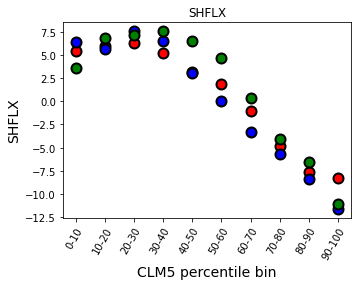

In [57]:
fig = plt.figure(figsize=(16,16))
ax = plotcomposite(shflxcomp_snowd[:,8], "SHFLX", "SHFLX", 0.05,0.3,0.8,0.97)
ax = oplotcomposite(ax, shflxcomp_clm5[:,8], color="blue")
ax = oplotcomposite(ax, shflxcomp_fnet[:,8], color="green")

In [48]:
print(netradcomp_snowd[:,8])

[11.00543404  8.25522423  7.01336622  5.83372307  4.55221748  3.44022918
  2.76923895  1.98618245  0.64198995 -1.14642894]


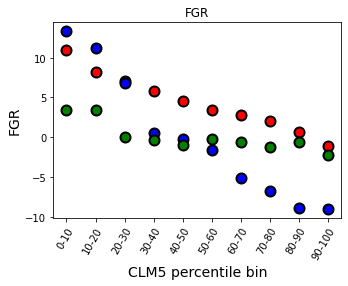

In [46]:
fig = plt.figure(figsize=(16,16))
ax = plotcomposite(netradcomp_snowd[:,8], "FGR", "FGR", 0.05,0.3,0.8,0.97)
ax = oplotcomposite(ax, netradcomp_clm5[:,8], color="blue")
ax = oplotcomposite(ax, netradcomp_fnet[:,8], color="green")

Text(0, 0.5, 'TREFHT (K)')

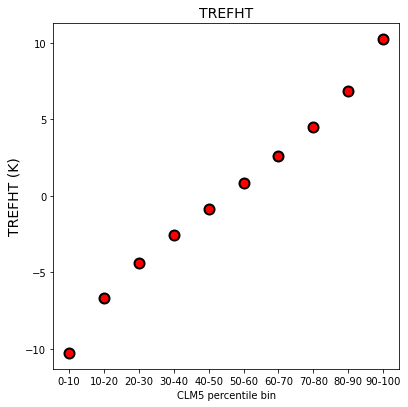

In [47]:
fig = plt.figure(figsize=(16, 16))

xticks = list(np.arange(0,10,1)+0.5)

ax = fig.add_axes(np.array([0.05,0.05,0.3,0.3]))
ax.plot(np.arange(0,10,1)+0.5,trefhtcomp_clm5,"o", markerfacecolor="red", markeredgecolor="black", markersize=10, markeredgewidth=2)
ax.set_xticks(xticks)
ax.set_xticklabels(['0-10','10-20','20-30','30-40','40-50','50-60','60-70','70-80','80-90','90-100'])
ax.set_title('TREFHT', fontsize=14)
ax.set_xlabel('CLM5 percentile bin')
ax.set_ylabel('TREFHT (K)',fontsize=14)


In [54]:
test = (djfanoms_np_1d[ (djfanoms_np_1d >= binmin[0]) & (djfanoms_np_1d <binmax[0])]).mean()

In [55]:
print(test)

-10.428715


In [53]:
print(djfanoms_np_1d[ (djfanoms_np_1d >= binmin[0]) & (djfanoms_np_1d <binmax[0])])

[ -8.617049   -8.308074  -10.015746  -11.11917   -10.50743    -8.778289
 -10.640792   -8.507893   -9.666752  -11.403294  -11.246983  -10.495808
 -12.002567   -8.411213  -10.227268   -9.563999  -13.5792885  -9.106968
  -8.491209   -9.8670635 -10.327055   -8.556608  -10.610807   -8.543135
  -8.417677  -10.30337   -12.964442  -10.5911665 -10.899837  -10.526423
  -9.983256   -9.760345  -13.55275   -13.287155   -8.971954   -8.433228
 -11.005663  -10.800661  -11.87462    -9.156389  -10.201601  -10.036882
 -11.889315   -8.440538  -11.511591   -8.364115  -13.455921   -9.891315
 -10.967106   -9.317265  -12.042316  -10.961002  -10.2121315 -11.105777
 -13.941272  -10.612567  -13.504458  -13.321795  -11.501086   -9.475345
 -10.62698    -8.80711   -12.630489  -12.327328  -12.776073  -12.433422
  -9.859859   -9.640667   -9.861416   -8.336697  -10.51733    -9.333889
  -8.626904  -12.760265  -11.657833  -12.806316  -10.036526   -9.065304
  -9.45982    -8.573049   -8.715322   -8.323567   -9.515645  -10

In [51]:
print(binmin)
print(binmax)

[-13.98566494  -8.2493515   -5.51611423  -3.35766249  -1.60746818
   0.06056097   1.78635674   3.50238435   5.52189856   8.33151293]
[-8.2493515  -5.51611423 -3.35766249 -1.60746818  0.06056097  1.78635674
  3.50238435  5.52189856  8.33151293 13.06537315]


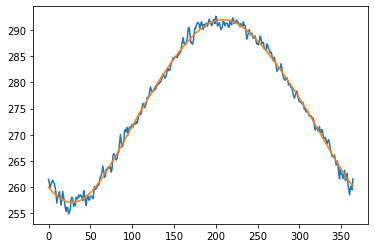

In [28]:
plt.plot(datseas)
plt.plot(dat4harm)

In [9]:
print(stationinfo)

   Station       Lon       Lat     yrange fend
0   CA-Gro  -82.1556  48.21670  2003-2014  NaN
1   CA-Man  -98.4808  55.87960  1994-2008  NaN
2   CA-Oas -106.1978  53.63580  1996-2010  NaN
3   CA-Obs -105.1178  53.98710  1997-2010  NaN
4   CA-SF1 -105.8176  54.48500  2003-2006  NaN
5   CA-SF2  -15.8775  54.25390  2001-2005  NaN
6   CA-TP1  -80.5595  42.66090  2002-2014  2-4
7   CA-TP2  -80.4588  42.66090  2002-2007  NaN
8   CA-TP3  -80.3483  42.70680  2002-2014  NaN
9   CA-TP4  -80.3574  42.71010  2002-2014  NaN
10  CA-TPD  -80.5577  42.63530  2012-2014  NaN
11  RU-Che  161.3414  68.61300  2002-2005  NaN
12  RU-Cok  147.4943  70.82910  2003-2014  2-4
13  RU-Fyo   32.9221  56.45153  1998-2014  2-4
14  RU-Ha1   90.0022  54.72520  2002-2004  NaN
